<a href="https://colab.research.google.com/github/MoAbbasid/Codespace-test/blob/main/Question3/TM_AssessmentQ3v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important: Change to GPU Runtime
***Please ensure you are on the T4 GPU***

## MultiModal RAG over PDFs with ColPali and Llama 3.2 11B Vision on Hosted Options

*To ensure the notebook runs faster please change the runtime type to T4 GPU:
`Runtime` -> `Change runtime type` -> `T4 GPU`*

[ColPali](https://arxiv.org/abs/2407.01449) is a new multimodal retrieval system that seamlessly enables image retrieval.

By directly encoding image patches, it eliminates the need for optical character recognition (OCR), or image captioning to extract text from PDFs.

`byaldi`, a library from [AnswerAI](https://www.answer.ai/) that makes it easier to work with ColPali and embed and retrieve images of our PDF document.

Retrieved pages will then be passed into the Llama-3.2 11B Vision model to produce responces.

***Huggingface*** is a popular library for serving and using open source models, sadly we can not use it for both our models(ColPali for Retrieval and Extraction, Llama-3.2 11B Vision for Text Generation and Chat Completion)
Because in Google colab we are limited in resource as the free T4 GPU only has 15GB of VRAM, which is not enough to both models (either/or).

Thus I have made the decision to load ColPali because its carries alot of the weight of this task, and look for another hosted option to infer the llm via API.

An API is communication layer and is how web application talk to each other, an API endpoint is like the destination in mail message.

What we will do is basically wrap the question (query) and relevant image in a message, and offload the whole llm text generation part to hosted option, we will explore the options later.


**tip: click on the cells to unroll the code**

### Install libraries

In [ ]:
!pip install byaldi together pdf2image gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [ ]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (153 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123629 

### Initialize the ColPali Model

In [ ]:
import os
from pathlib import Path
from byaldi import RAGMultiModalModel

# Initialize ColiPali Model from pretrained checkpoint, This step takes some time
COL = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Lets create our index that will store the embeddings for the page images.

In [ ]:
# Index the paper using ColPali model
filepath = "/content/COVID19_sitrep_MYS_w-46--47.pdf"
index_name = "covid_index"
COL.index(input_path=Path(filepath),
    index_name=index_name,
    store_collection_with_index=False,
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Index exported to .byaldi/covid_index
Index exported to .byaldi/covid_index


{0: '/content/COVID19_sitrep_MYS_w-46--47.pdf'}

### Let's query our indexed document.

Here the important thing to note is that the query is asking for a very specific detail that is found only in table on page 5 of the PDF!

In [ ]:
# Lets query our index and retrieve the page that has content with the highest similarity to the query

query = "Which two states had the highest 14-day positivity rates, and what were the rates?"
results = COL.search(query, k=3) # as simple as model.search(query), u can modify k to choose number of returned queries
results

[{'doc_id': 0, 'page_num': 2, 'score': 27.125, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 4, 'score': 26.875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 1, 'score': 25.5, 'metadata': {}, 'base64': None}]

*** Notice that page 1 and 2 have matching 'score' is because both pages have the desired answer, we will inspect both of them below***

### Notice that ColPali is able to retrieve that correct page with the highest similarity!

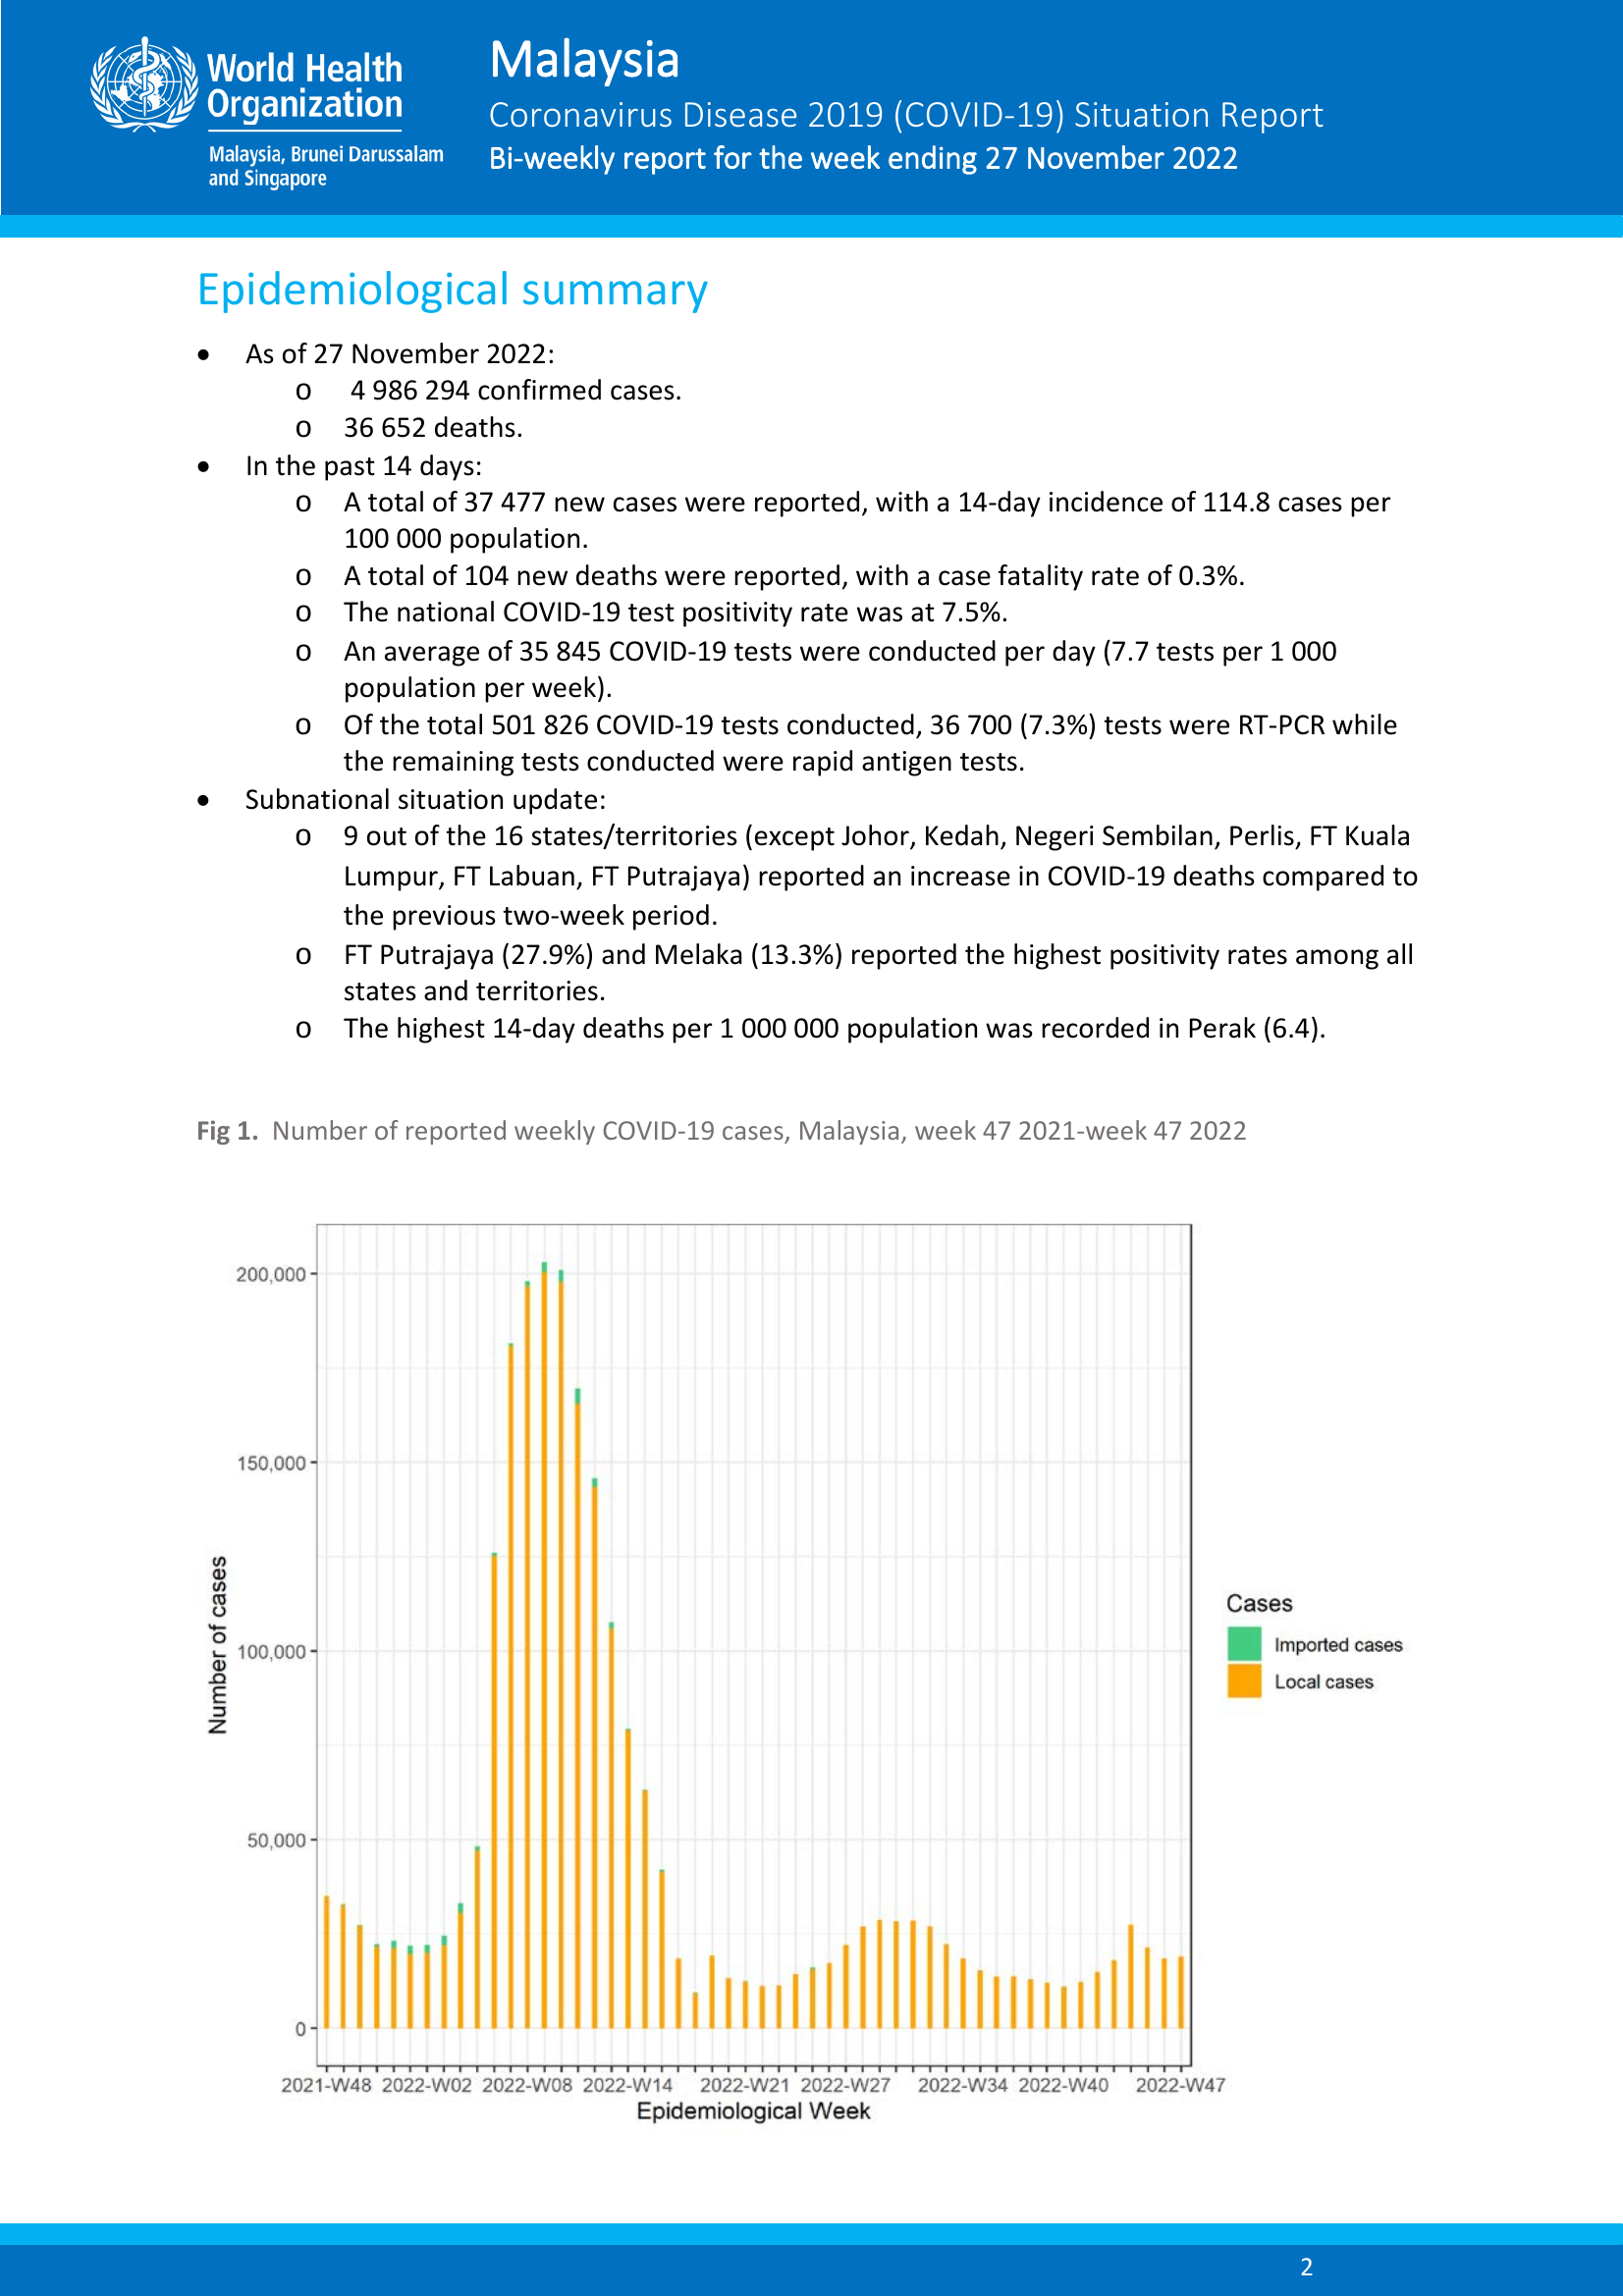

In [ ]:
from pdf2image import convert_from_path

# Lets look at the page with the highest similarity to the query
# Notice that the answer to the query is actually present in this page
# ColPali correctly retrieved it
images = convert_from_path(filepath)

# retrieve the page_num for the query with the highest score
image_index = results[0]["page_num"] - 1

#Save and display page 5
# images[0].save("retrieved_page.jpg")
images[image_index]

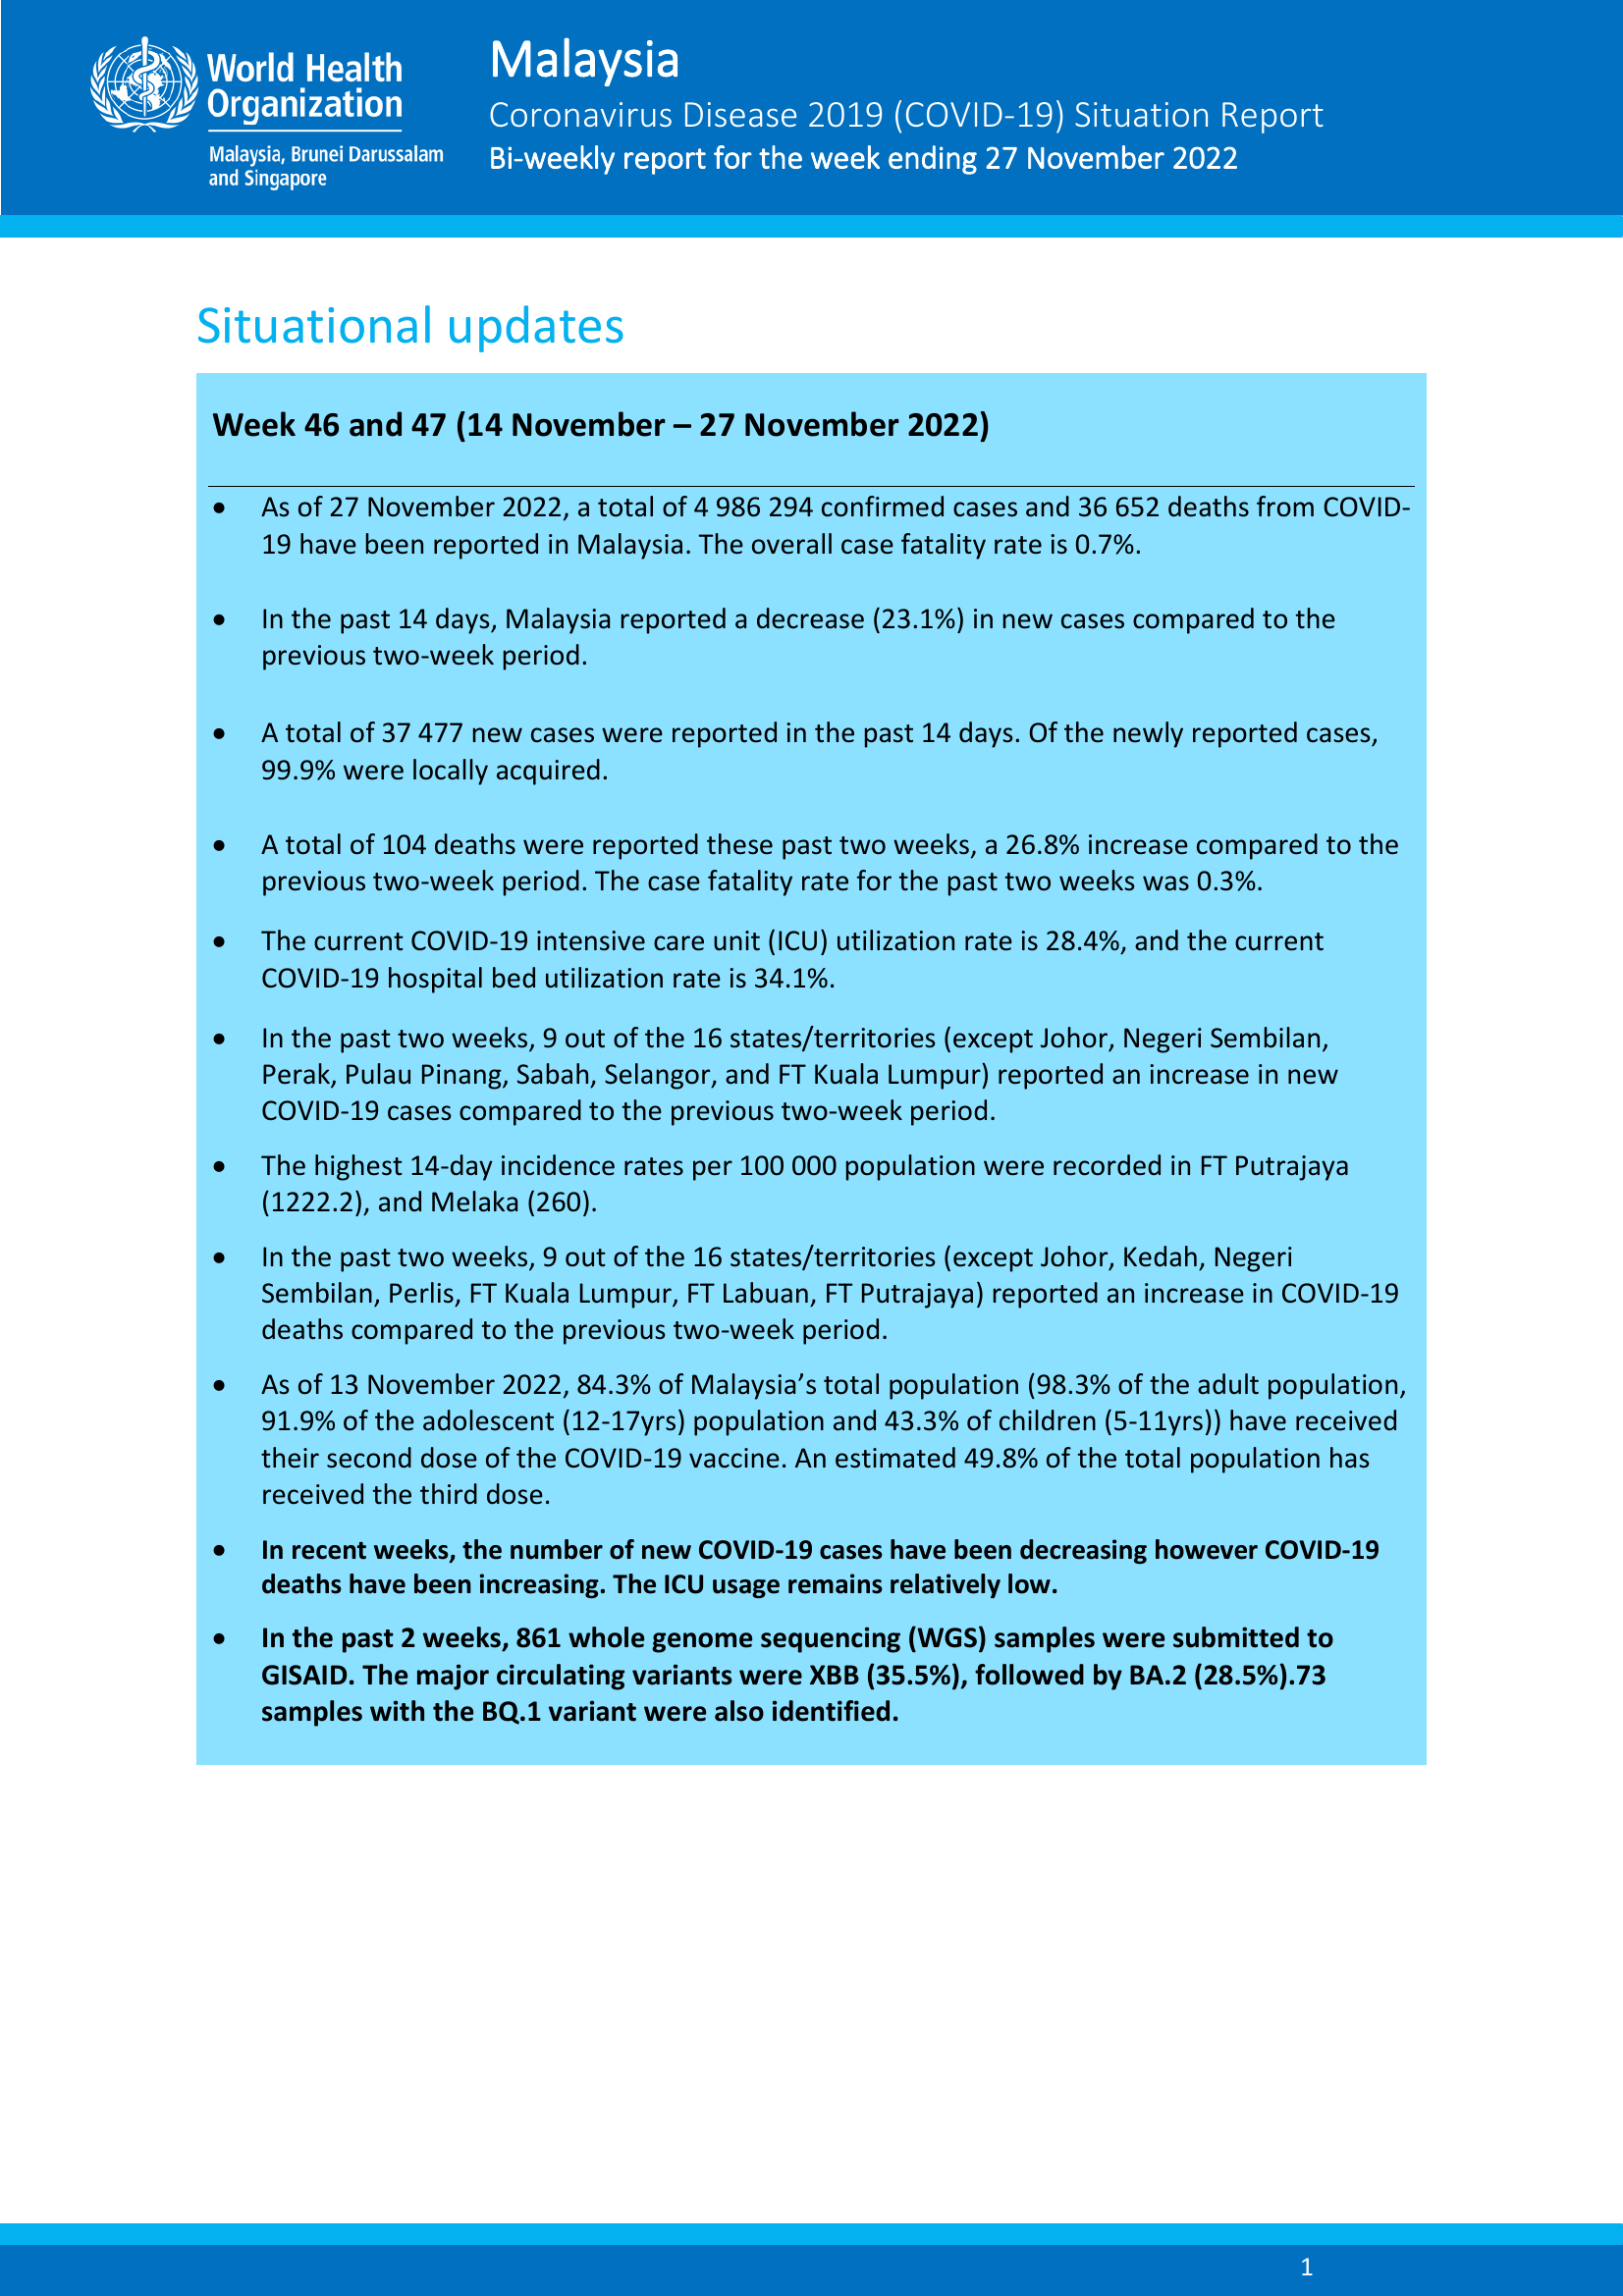

In [ ]:
# Inspect second index
image_index2 = results[0]["page_num"] - 2

#Save and display page 5
# images[0].save("retrieved_page.jpg")
images[image_index2]

### Now Lets encode our image to base64 (because Llama model input formatting, Qwen VL has different formatting)

In [ ]:
import base64
from io import BytesIO

# Function to encode the image to base64
def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# pass the page with the highest index to encode image and return b64 encoded page
retrieved_page_b64 = encode_image(images[image_index])
print(retrieved_page_b64)

### Lets now pass in the retrieved page to the Llama-3.2 11B Vision Model.

This model will read the question specified by query

And take in the retrieved page and produce an answer!

You can pass in a URL to the image of the retrieved page or a base64 encoded version of the image.

***First we define a system prompt to help direct the model***

In [ ]:
# System prompt to direct the model
system_prompt = """
<|system|>
You are a PDF Question Answering assistant.
You will receive a query as text and an image of the retrieved context from the document.
Use the provided information to answer concisely and accurately.
Double-check your answers.
If you don't know the answer, just say you don't know. Do not make any information up.
<|end|>
"""


In [ ]:
# another try
system_prompt2 = """
<|system|>
You are a PDF Question Answering assistant.
You will mreceive a query as text and an image of the retrieved context from the document.
Use the provided information to answer concisely and accurately.
Double-check your answers.
If you don't know the answer, just say you don't know. Do not make any information up.
<|end|>
<|begin_of_text|><|start_header_id|>user<|end_header_id|>
<|image|>{query}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""


In [ ]:
query2 = "What was the positivity rate in FT Putrajaya over the last 14 days?"

### first We'll test a Together.ai inference endpoint to access the Llama-3.2 11B Vision model

In [ ]:
from together import Together
import requests
import json

# Trying with Together inference option

# client = Together(api_key=os.environ.get("TOGETHER_DEV_API_KEY"))
api_endpoint ='https://api.together.xyz/v1/chat/completions'

# Again the api_key should not be exposed only left here for your reproducability ease
api_key = '6237afdcdafab349d9ef86b03a004c135c21f222d810a393a9db538939363886'
client = Together(api_key=api_key)

data = json.dumps({
    "model": "meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo", # model name
    "max_tokens": 100,
    "messages":[
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {"type": "text",
                 "text": query # query
                 },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{retrieved_page_b64}" #retrieved page image
                    }
                }
            ]
        }
    ],
    "stream": False,
    "logprobs": False,
})

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# send post request with the payload=data to
together_response = requests.post(api_endpoint, headers=headers, data=data)

In [ ]:
# print response
together_response.json()['choices'][0]['message']['content']

'The total number of confirmed COVID-19 cases as of 27 November 2022 was 4,986,294.'

***It was delivering the payload and coming up with response when Im testing but perhaps I exceeded my Quota since iam on a free account, one of the things to keep in mind about hosted models***

### Next lets test with Open Router Indference platform, the pross is similar with the only changes in api_endpoint(the adress) and the auth token.

In [ ]:
    filepath = "/content/COVID19_sitrep_MYS_w-46--47.pdf"
    index_name = "covid_index"
    query = "What was the total number of confirmed COVID-19 cases as of 27 November 2022?"
    results = COL.search(query, k=3)
    images = convert_from_path(filepath)
    image_index = results[0]["page_num"] - 1
    image_index2 = results[0]["page_num"] - 2
    image = images[image_index]
    image2 = images[image_index2]
    retrieved_page_b64 = encode_image(image)
    retrieved_page_b642 = encode_image(image2)

In [ ]:
# define endpoint to hit
or_api_endpoint = "https://openrouter.ai/api/v1/chat/completions"

# Again the api_key should not be exposed only left here for your reproducability ease
or_key = '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'

headers = {
    "Authorization": f"Bearer {or_key}",
    "Content-Type": "application/json"
}

data = json.dumps({
    "model": "meta-llama/llama-3.2-11b-vision-instruct:free",
    "max_tokens": 40,  # the open router version tends to yap, we set this to prevent the model from yapping
    "temperature": 0.6,
    "messages": [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": query
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{retrieved_page_b64}", #retrieved page image
                    }
                }
            ]
        }
    ]
})

# send post request
or_response = requests.post(
    url=or_api_endpoint,
    headers=headers,
    data=data
)

In [ ]:
or_response.json()

{'id': 'gen-1729025741-gJgThhP3V4FKnV9W8s83',
 'provider': 'Together',
 'model': 'meta-llama/llama-3.2-11b-vision-instruct:free',
 'object': 'chat.completion',
 'created': 1729025741,
 'choices': [{'logprobs': None,
   'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'As of 27 November 2022, the total number of confirmed COVID-19 cases was 4,986,294.',
    'refusal': ''}}],
 'usage': {'prompt_tokens': 112, 'completion_tokens': 27, 'total_tokens': 139}}

**we see the model provided us with an accurate answer**

In [ ]:
# inspect json for error for handling later
json.loads(or_response.json()['error']['message'])['error']['message']
# or_response.json()['error']['message']['error']['message']

'You have been rate limited for model meta-llama/Llama-Vision-Free. Your rate limit is 10.000000002 queries per minute. Please navigate to https://api.together.xyz/settings/billing to upgrade your plan and see your limit.'

In [ ]:
# Extract the nested error message
nested_error_message = json.loads(or_response.json()['error']['message'])['error']['message']

print(nested_error_message)


You have been rate limited for model meta-llama/Llama-Vision-Free. Your rate limit is 10.000000002 queries per minute. Please navigate to https://api.together.xyz/settings/billing to upgrade your plan and see your limit.


#### test

In [ ]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_index("covid_index")
RAG

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))


In [ ]:
del query

### Lets proceed with Open Router (because its free 😉) and build a Gradio Demo ###

**Full Demo Code: This is the full standalone demo code, you can run these alone to generate the gradio demo, so you dont have to follow step by step from earlier**

1. First Run takes a bit of time (few minutes) subsequent runs should be
faster.
2. Keep an eye out for GPU RAM in the resources section in Colab to see that Colpali model alone almost took out the whole memory
3. Even tho Open Router is serving this model for free, its rate limited, if you send too many concurrent request using the same api key you will get an error json response, you can check if youre rate limited in the Gradio cell output in the line "response from api:...",,
4. In case of rate limit wait for a few minutes then try again

In [ ]:
import json
import requests
from pathlib import Path
from pdf2image import convert_from_path
from byaldi import RAGMultiModalModel
import gradio as gr
import base64
from PIL import Image
import io
import os

# Global vars
COL = None
index_name = "covid_index"
or_api_endpoint = "https://openrouter.ai/api/v1/chat/completions"
or_key = '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'
index_flag_file = 'index_created.flag'

def initialize_model():
    """
    Initialize the model if it hasn't been loaded yet.
    """
    global COL
    if COL is None:
      if not os.path.exists(index_flag_file):
        COL = RAGMultiModalModel.from_pretrained("vidore/colpali")
        print('Model initilised from pretrained')
      elif os.path.exists(index_flag_file):
        COL = RAGMultiModalModel.from_index(index_name)
        print('Model initilised from index')

def create_index(filepath):
    """
    Create a new index for the given filepath.
    """
    global COL
    initialize_model()
    COL.index(input_path=Path(filepath),
              index_name=index_name,
              store_collection_with_index=False,
              overwrite=True)

    # Create a flag file to indicate the index has been created
    with open(index_flag_file, 'w') as f:
        f.write(f"Index created for {filepath}")



def encode_image(image):
    """
    Encode the given image to base64.
    """
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def main(filepath, prod_query):
    """
    Main function to orchestrate RAG workflow.
    """
    global COL

    initialize_model()
    if not os.path.exists(index_flag_file):
        create_index(filepath)
    elif COL is None:
        # If the index exists but the model was reloaded, we need to reinitialize
        initialize_model()

    results = COL.search(prod_query, k=3)
    print(f'the prod_query being passed is: {prod_query}')
    images = convert_from_path(filepath)
    image_index = results[0]["page_num"] - 1
    image_index2 = results[0]["page_num"] - 2
    image = images[image_index]
    image2 = images[image_index2]
    image_b64 = encode_image(image)
    image_b642 = encode_image(image2)

    headers = {
        "Authorization": f"Bearer {or_key}",
        "Content-Type": "application/json"
    }

    data = json.dumps({
        "model": "meta-llama/llama-3.2-11b-vision-instruct:free",
        "max_tokens": 40,
        "temperature": 0.4,
        "messages": [
            {
                "role": "system",
                "content": "You are a PDF Question Answering assistant. You will receive a prod_query as text and an image of the retrieved context from the document. Use the provided information to answer concisely and accurately. Double-check your answers. If you don't know the answer, just say you don't know. Do not make any information up."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prod_query
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_b64}"
                        }
                    }
                ]
            }
        ]
    })

    # send post request
    or_response = requests.post(
        url=or_api_endpoint,
        headers=headers,
        data=data
    )

    try:
        response_json = or_response.json()
        print(f'response from api:\n {response_json}')

        if 'choices' in response_json:
            # if response is normal extract content and assign to answer
            answer = response_json['choices'][0]['message']['content']
        else:
            # if response is error extract message and assign to answer
            answer = json.loads(or_response.json()['error']['message'])['error']['message']

    except (KeyError, IndexError, ValueError) as e:
        answer = f"Error processing the response: {e}"

    return image, answer

In [ ]:
iface = gr.Interface(
    fn=main,
    inputs=[
        gr.File(type="filepath", label="Upload PDF file (context)"),
        gr.Textbox(type="text", label="Enter Question"),
    ],
    outputs=[
        gr.Image(type="pil", label="Retrieved Page"),
        gr.Textbox(type="text", label="The Answer")
    ],
    title="TM Assessment Q3v2",
    description="Upload a PDF file and ask a question. The answer and the relevant page will be displayed.",
    examples=[
      ["COVID19_sitrep_MYS_w-46--47.pdf", "What was the total number of confirmed COVID-19 cases as of 27 November 2022?"],
      ["COVID19_sitrep_MYS_w-46--47.pdf", "What was the positivity rate in FT Putrajaya over the last 14 days?"],
      ["COVID19_sitrep_MYS_w-46--47.pdf", "How many COVID-19 deaths were reported in the past two weeks?"],
      ["COVID19_sitrep_MYS_w-46--47.pdf", "What was the cumulative positivity rate for COVID-19 testing since 1 January 2022?"],
      ["COVID19_sitrep_MYS_w-46--47.pdf", "Which two states had the highest 14-day positivity rates, and what were the rates?"]
    ]
)

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0d3cd8ac2c95638dc0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))


Model initilised from index
the prod_query being passed is: What was the total number of confirmed COVID-19 cases as of 27 November 2022?
response from api:
 {'id': 'gen-1729027142-wrScbz2y2N0rbftUY0CS', 'provider': 'Together', 'model': 'meta-llama/llama-3.2-11b-vision-instruct:free', 'object': 'chat.completion', 'created': 1729027142, 'choices': [{'logprobs': None, 'finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': 'As of 27 November 2022, the total number of confirmed COVID-19 cases was 4,986,294.', 'refusal': ''}}], 'usage': {'prompt_tokens': 103, 'completion_tokens': 27, 'total_tokens': 130}}
the prod_query being passed is: Which two states had the highest 14-day positivity rates, and what were the rates?
response from api:
 {'id': 'gen-1729027157-V2FNKAprVGJBe8u6IgWM', 'provider': 'Together', 'model': 'meta-llama/llama-3.2-11b-vision-instruct:free', 'object': 'chat.completion', 'created': 1729027157, 'choices': [{'logprobs': None, 'finish_reason': 'le

Here we can see that the combination of ColPali as a image retriever and Llama-3.2 11B Vision is a powerful duo for multimodal RAG applications specially with PDFs.

Not only was ColPali able to retrieve the correct page that had the right answer on it but then Llama-3.2 11B Vision was also able to find exactly where on the page this answer was, ignoring all the irrelvant details!

ColPali is SOTA for retrieval at the moment